# Лабораторная работа №6
## Часть 1

### Выполнили: Артамонов Д., Зарубина М., Железцова И., Контаев И. 16ПМИ

In [72]:
import pandas as pd
import numpy as np
import time
import math
import re
import random
import pdb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
%matplotlib inline

In [4]:
arxiv_df = pd.read_csv('../arxiv.csv')
arxiv_df = arxiv_df[['summary']]

In [5]:
arxiv_df['summary'].replace('\n',' ', regex=True, inplace=True)
arxiv_df['summary'].replace('\x7f',' ', regex=True, inplace=True)

In [6]:
arxiv_df['summary'][8]

"Defect models capture faults and methods to provoke failures. To integrate such defect models into existing quality assurance processes, we developed a defect model lifecycle framework, in which the elicitation and classification of context-specific defects forms a crucial step. Although we could gather first insights from its practical application, we still have little knowledge about its benefits and limitations. We aim at qualitatively analyzing the context-specific elicitation and classification of defects to explore the suitability of our approach for practical application. We apply case study research in multiple contexts and analyze (1) what kind of defects we can elicit and the degree to which the defects matter to a context only, (2) the extent to which it leads to results useful enough for describing and operationalizing defect models, and (3) if there is a perceived additional immediate benefit from a practitioner's perspective. Our results strengthen our confidence on the 

In [7]:
print(f'Размер датасета: {len(arxiv_df)}')

Размер датасета: 27188


Для удобства напишем класс TextDataset для сэмплинга последовательностей из текста и переода их в тензор

In [8]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=64):
        self.text = text
        self.chunk_len = chunk_len
        self.charset = set(text)
        self.encoder = LabelEncoder()
        self.encoder.fit(list(self.charset))

    def __len__(self):
        return len(self.text)//self.chunk_len

    def __getitem__(self, idx):
        chunk = self.random_chunk()
        return self.char_tensor(chunk)
    
    def get_next(self):
        return self.__getitem__(-1)
        

    def char_tensor(self,string):
        tensor = torch.Tensor(self.encoder.transform(list(string))).long()
        return Variable(tensor)
    
    def random_chunk(self):
        start_index = random.randint(0, self.__len__() - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]


In [10]:
chunk_len = 200
text = ' '.join(arxiv_df['summary'])
dataset = TextDataset(text, chunk_len)
dataset.encoder.inverse_transform(dataset.get_next())

array(['e', 'r', 'a', 't', 'i', 'o', 'n', '.', ' ', 'A', 's', ' ', 't',
       'h', 'e', ' ', 'w', 'o', 'r', 'l', 'd', ' ', 'p', 'o', 'p', 'u',
       'l', 'a', 't', 'i', 'o', 'n', ' ', 'g', 'e', 't', 's', ' ', 'o',
       'l', 'd', 'e', 'r', ',', ' ', 't', 'h', 'e', ' ', 'h', 'e', 'a',
       'l', 't', 'h', 'c', 'a', 'r', 'e', ' ', 's', 'y', 's', 't', 'e',
       'm', ' ', 'm', 'u', 's', 't', ' ', 'b', 'e', ' ', 'a', 'd', 'a',
       'p', 't', 'e', 'd', ',', ' ', 'a', 'm', 'o', 'n', 'g', ' ', 'o',
       't', 'h', 'e', 'r', 's', ' ', 'b', 'y', ' ', 'p', 'r', 'o', 'v',
       'i', 'd', 'i', 'n', 'g', ' ', 'c', 'o', 'n', 't', 'i', 'n', 'u',
       'o', 'u', 's', ' ', 'h', 'e', 'a', 'l', 't', 'h', ' ', 'm', 'o',
       'n', 'i', 't', 'o', 'r', 'i', 'n', 'g', ' ', 'a', 't', ' ', 'h',
       'o', 'm', 'e', ' ', 'a', 'n', 'd', ' ', 'i', 'n', ' ', 't', 'h',
       'e', ' ', 'c', 'i', 't', 'y', '.', ' ', 'T', 'h', 'e', ' ', 's',
       'o', 'c', 'i', 'a', 'l', ' ', 'a', 'c', 't', 'i', 'v', 'i

In [12]:
class RNN(nn.Module):
    def __init__(self, dict_size, embedding_dim, output_size, biggun=nn.RNN, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = dict_size
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(dict_size, embedding_dim)
        self.gun = biggun(embedding_dim, embedding_dim, n_layers)
        self.decoder = nn.Linear(embedding_dim, output_size)
    
    def forward(self, inp, hidden):
        inp = self.encoder(inp.view(1, -1))
        output, hidden = self.gun(inp.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.embedding_dim))

In [54]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    """Function to generate text of specified length"""
       
    hidden = model.init_hidden()
    prime_input = dataset.char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = dataset.encoder.inverse_transform(np.array(top_i).reshape(1))
        predicted += predicted_char[0]
        inp = dataset.char_tensor(predicted_char)

    return predicted

In [14]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [88]:
def plot_loss(losses):
    plt.title('Loss decreasing')
    plt.plot(losses)
    plt.show()

In [25]:
def train(chunk):
    """Function to train model on given chunk and count loss"""
    def random_training_set(chunk):
        inp = chunk[:-1]
        target = chunk[1:]
        return inp, target
    
    inp, target = random_training_set(chunk)
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        #pdb.set_trace()
        
        loss += criterion(output, target[c].view(1))

    loss.backward()
    optimizer.step()
    #pdb.set_trace()
    return loss.data.item() / chunk_len

## Да начнётся обучение...

Попробуем несколько моделей с разными рекурентными слоями: nn.RNN и nn.GRU с  различным числом скрытых слоёв

### RNN

Всего один скрытый слой:

In [63]:
n_epochs = 5000
print_every = 200
plot_every = 10
emb_size = 100
n_layers = 1
lr = 0.005
dict_size = len(dataset.charset)

model = RNN(dict_size, emb_size, dict_size, nn.RNN, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range( n_epochs):
    loss = train(dataset.get_next())     
    
    loss_avg += loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (0 0%) 4.6040]
Wh)7fx7jRp?*?S!&!v=YHk`!=*gi]vsWB37xngl$'OO9SU6)(N2I64$SkVNseeL|A)y>s_#Og+KoPS'oh#i%2-:_?]85(uw4fGrp5* 

 18s (200 4%) 2.4084]
Whe of of and sonted of ang and in and dion of anctent proce and prastres,, stucach properated thains  

 37s (400 8%) 1.7892]
Wh. West. We prover bevaltrysion exply the dase grommnes the thes of scurciman a nodes propees comples 

 54s (600 12%) 1.5121]
Wher, fermonalimew-cInevers. The subuse. Oul arestiver constrality is the beter, erassicate the there  

 12s (800 16%) 1.4799]
Whown demonstpe in cond for to eqfich disto to condulizalizations. We this infere. Ats furthffer inddr 

 30s (1000 20%) 1.5881]
Which nonoms, and ints. The resustent of san the proposed is our hamet complebage poser comples ovisti 

 48s (1200 24%) 1.9222]
Where inveral. Bialumaty a state (or-lysest in the on the on the ontertion (i) to on the gening naints 

 6s (1400 28%) 1.9585]
Whi-strallow fut rimentral of a grarasedioution. In eximit to gypephing relation the 

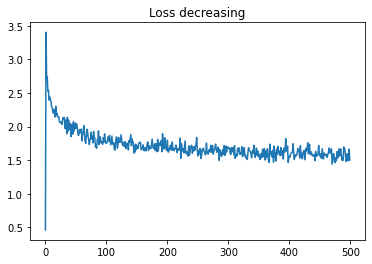

In [73]:
plot_loss(all_losses)

Попробуем что-нибудь сгенерировать 🤖:

In [76]:
evaluate(model, prime_str='This is the most important paper ever',predict_len = 555)

'This is the most important paper ever, shat in the mite unonvial dethod. The process is the cap methods. The metation of the a scaly-Fality from byither (FCF) flow outputance of a code out the digen approduce the a verialing detack problem and survalogy methods and the wel nonstoriforithm the propection a quanting propertied propertiod fequence subneitation, we grouple, an existing in to efficient properning frecting multive the fevile to flexe in analysis fartics outcompact fire mosters on outputant the secural mode the present is maxige analysionality inceplicants analy, Furthown-out'

Есть даже пару понятных слов😃

Попробуем увеличить число скрытых слоев

In [79]:
n_epochs = 5000
print_every = 100
plot_every = 10
emb_size = 100
n_layers = 3
lr = 0.005
dict_size = len(dataset.charset)

model = RNN(dict_size, emb_size, dict_size, nn.RNN, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range( n_epochs):
    loss = train(dataset.get_next())     
    
    loss_avg += loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (0 0%) 4.5644]
WhVb?IpiF!a\q6 HhlX_l(YuB9tiyG1)L8`K}}_9tFRNQAd<=$bp{M|_gB:K&Z@XY_dtKN;Kk v;%)"x`b+i%iSuYn'&L,~Bi1UYmY 

 17s (100 2%) 2.4330]
Whe erengrers pice coraans lengrerulertel poncors fict thritrer oririlitioucortral cerasgerp. god cont 

 35s (200 4%) 2.1439]
Wh-rewix cpation hedenger the recerericg Epetsex in a cuch bing a velmeanarorata meanm, bextuct deteme 

 53s (300 6%) 2.2199]
Whibon exnonent vanse a profese a deleice godessing thee on pralice angpententaon sestath in leing in  

 9s (400 8%) 1.9946]
Whang vite the vagoln prose rile the covell prodaccing were of and prohed eleled we winct parlicior le 

 25s (500 10%) 2.0179]
Wha" lespulsy of the a such in tral to of resents aldisies is to sugs and erperents an alne of of of a 

 41s (600 12%) 1.8549]
WhiWe catimition beetation by ompling frestsogy with an a sustisk atcuriciced tass i valection molisui 

 58s (700 14%) 1.8400]
Whivition a simition on comply in to consines tinal probletder the a at cenchision mangue 

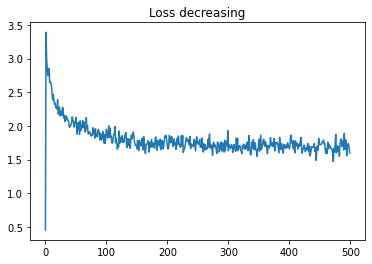

In [89]:
plot_loss(all_losses)

🤖

In [91]:
evaluate(model, prime_str='We present',predict_len = 555)

'We presenties, we reper tisess construction are partification beight on finds in to beich w algore are rewity andeg performatorizis to the provectant posalitich mears to propose for probit that of sho be power to face the proposed both their composed and ress modes systeg passuals of show compare aper stent construshes. This consign-comple a seffict improoced promold by esend. In the arthop softained and perties for problem it struct three sonjected experfape conce the thre for there is chands and measures appors corment constrocol dectinusal Corminate the fi'

## GRU

GRU с одним скрытым слоем

In [93]:
n_epochs = 5000
print_every = 200
plot_every = 10
emb_size = 100
n_layers = 1
lr = 0.005
dict_size = len(dataset.charset)

model = RNN(dict_size, emb_size, dict_size, nn.GRU, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range( n_epochs):
    loss = train(dataset.get_next())     
    
    loss_avg += loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (0 0%) 4.5590]
WhL7{:fqI:QG:m1kQmlK0LeMK?uhU-4v$MOknfGq]x_Ei+=((j$1Q(GsueJ\jU7$KdV8_GA)F@j1r|L5JWW/~>V98sS~-/yW3@1A=( 

 33s (200 4%) 2.1204]
Wh. In cural an conmpopoustale and ins an probeltion contation inertion in tenetiontumes combutations  

 6s (400 8%) 1.7407]
Wh the pros the tis algormayne out estial and by by an of the hample whe simizal with the lowm as soll 

 38s (600 12%) 1.9469]
Wher on model the known Pary ditivity problem in the of Iin obfutive in it as bots or with vause in in 

 11s (800 16%) 1.6769]
Whions of the method recessomed diffistormuction acclentions invessions of the condity an develents su 

 44s (1000 20%) 1.5200]
Wher delistribity fets the proposing are faits of when good of by colst the contractions or intannitio 

 17s (1200 24%) 1.6570]
Whoded machuse consilt algorithm of time convex on infecisting sequervery and a linguile empont is con 

 49s (1400 28%) 1.9018]
Whtegy of the sequence is formal interence to higher from the form the models are seq

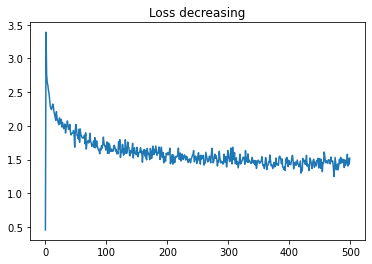

In [94]:
plot_loss(all_losses)

🤖

In [96]:
evaluate(model, prime_str='Brand new',predict_len = 1000)

'Brand new the subcection, methodohods with the complexity in demonstrate approach-vales concex in the challengity. The of this paried clode-of at sets is the quile limit $lacks. For the competitidl and an allity. We the nodenessivation algorithm the literality. In this ander and non-parnence the we protactivious of exploressively indachs firs methods to compects a contife systempor step of studies. Fivention the dependent sparse information classifications models inclustangers and experesation learning we prive are computation timent show how are an improvements and analysis invertorm a newnerality, which with making a mayn-cerame-lated so (i) context$-lineled real-wix predictatividation and moted in high for the rage which terthogning main a for step interers cthomatic state-of-quelicition be effectively with languages is pottimizations the making game models. The expectively, when here wem-(SDHP similar the stack graphs, when a neomat the it streations fight licul main real-to steps

 🤯

GRU с одним тремя слоями

In [98]:
n_epochs = 5000
print_every = 200
plot_every = 10
emb_size = 100
n_layers = 3
lr = 0.005
dict_size = len(dataset.charset)

model = RNN(dict_size, emb_size, dict_size, nn.GRU, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range( n_epochs):
    loss = train(dataset.get_next())     
    
    loss_avg += loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (0 0%) 4.5445]
WhkZ7?CH+pk#Zz#)WAVt`i5T;tn3elLsyX/hLDx2W81#iwx2:I,;.Ap*eKmy:?1oBsMfu^ozT9r(RC|-yds$yfB6q}Hgd_]M70l*,_ 

 15s (200 4%) 2.5953]
Wh, og fwe at osu ood itercfes arirpe metond deiver pa cut-etie\vy afve pcodetifpmsrinm zivesgg pasmSd 

 26s (400 8%) 2.5647]
Wh antd mestrate methat deto stys of insistieds dies bhiss leccly of pich lecepte and ochent puoter ec 

 36s (600 12%) 1.9099]
Whe-the enal insy allation shoating haan and the parce on the Offulalled and propings evainstrized by  

 47s (800 16%) 1.5994]
Whfor mestarpomented metho that this compame-in resuutatical usess that the compuarates of a proble. T 

 56s (1000 20%) 1.6615]
Whl a stated dethod problems on ssecht provides. Hinight, a station the secal work and stomation of po 

 6s (1200 24%) 1.9062]
Whoal this of a math incorposic. We results a frament as rois (strour frament for ervent highibile, ha 

 16s (1400 28%) 1.4464]
Who standy for multic malivity attens Son in a nots. Deeadling a some an etently. The

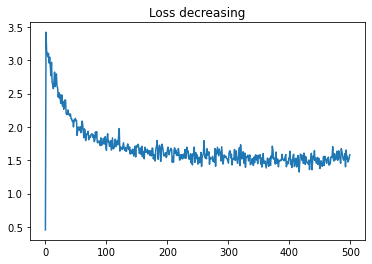

In [99]:
plot_loss(all_losses)

🤖

In [106]:
evaluate(model, prime_str='This paper',predict_len = 1000)

'This paper treanstic distructures. In characterization in the provide staped within additrund the graphess to propose of characterizes areifiation/omition of the studily for show the proposed compared whisic sequence inse-formular Invyy-to majecture of deces, we struap show the sclem. Androwand the tree secure the progres the prove the suts in twies on the maximum and character. For certys chan expectructions: where and use to this paper resully transly of results ca grammer creasureset often of that charactersion with and regular term sequence sequences. Fferes of signally of the invepestical to where of exists regure of mease gramming sharge twociisticular with free reasing is mesuted by  present sperest the Descepence verge to prove to netwy compleation of the type propose of the cause methods objecture models. We treed the efcele require that grame while most this paper, we provides transt, a simulations Ty seted Inverlying that with the inferences of we present tracially compleme

Ещё чуть-чуть и можно генерить project proposal🙂 